## Read the results from the json files in pg training-runs

In [1]:
import os
import json
import numpy as np
from tqdm import tqdm

import dnnlib
import torch
import legacy
from pg_modules.networks_fastgan import Generator
from training import loss

BASE_PATH = "mlcloud_runs/"
device = torch.device(
    'cuda') if torch.cuda.is_available() else torch.device('cpu')


In [2]:
import os
import random
import json
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
import json

class Image_Dataset(Dataset):
    def __init__(self, split='train', max_num_samples=np.inf, resolution=(128, 128), root_dir="/home/benedikthopf/Dokumente/9. Semester/datasets/CANDLE", filetype="png"):
        super(Image_Dataset, self).__init__()
        self.resolution = resolution

        assert split in ['train', 'val', 'test']
        self.split = split
        self.root_dir = root_dir
        # self.root_dir = "/home/benedikthopf/Dokumente/9. Semester/datasets/CLEVER/images/train"
        self.files = [file for file in os.listdir(
            self.root_dir) if file.endswith(f".{filetype}")]
        if len(self.files) > max_num_samples:
            self.files = self.files[:max_num_samples]
        self.img_transform = transforms.Compose([
            transforms.ToTensor()])

    def __getitem__(self, index):
        path = self.files[index]
        image = Image.open(os.path.join(self.root_dir, path)).convert("RGB")
        image = image.resize(self.resolution)
        image = self.img_transform(image)
        sample = {'image': image}

        return sample

    def __len__(self):
        return len(self.files)
    
class CLEVER(Image_Dataset):
    def __init__(self, split='train', max_num_samples=np.inf, max_num_objects=6, **kwargs):
        if "root_dir" not in kwargs.keys():
            kwargs["root_dir"] = "/home/benedikthopf/Dokumente/9. Semester/datasets/CLEVER/images/train"

        super().__init__(
            split,
            max_num_samples=np.inf,
            **kwargs
        )
        with open("/home/benedikthopf/Dokumente/9. Semester/datasets/CLEVER/scenes/CLEVR_train_scenes.json", "r") as f:
            scenes = json.load(f)

        self.max_num_objects = max_num_objects
        valid_scenes = list(filter(lambda x: len(
            x["objects"]) <= max_num_objects, scenes["scenes"]))
        valid_image_numbers = set(
            map(lambda x: x["image_filename"], valid_scenes))
        self.files = list(filter(
            lambda x: x in valid_image_numbers,
            self.files
        ))
        if len(self.files) > max_num_samples:
            self.files = self.files[:max_num_samples]

        self.files = sorted(self.files)
        self.scenes = sorted(valid_scenes, key=lambda x: x["image_filename"])

        with open("/home/benedikthopf/Dokumente/9. Semester/datasets/CLEVER/questions/CLEVR_train_questions.json", "r") as f:
            questions = json.load(f)["questions"]
        self.questions_by_image_index = {}
        for question in questions:
            i = question["image_index"]
            try:
                self.questions_by_image_index[i].append(question["question"])
            except KeyError:
                self.questions_by_image_index[i] = [question["question"]]

    def get_picture_object_count(self, file, scenes):
        for scene in scenes["scenes"]:
            if scene["image_filename"] == file:
                return len(scene["objects"])
        raise Exception(f"filename {file} not in scenes!")

    def __getitem__(self, index):
        path = self.files[index]
        image = Image.open(os.path.join(self.root_dir, path)).convert("RGB")
        image = image.resize(self.resolution)
        image = self.img_transform(image)

        o = self.scenes[index]["objects"]
        dummy = dict(o[0])
        dummy["shape"] = "None"  # dummy object, since the dataloader wants it
        objects = np.array([dummy for _ in range(self.max_num_objects)])
        for i in range(len(o)):
            objects[i] = o[i]
        objects = list(objects)

        sample = {
            'image': image,
            'question': np.random.choice(self.questions_by_image_index[index]),
            'objects': objects
        }

        return sample

In [3]:
folders = filter(lambda x: "gen" in x and "disc" in x, os.listdir(BASE_PATH))
folders = map(lambda x: os.path.join(BASE_PATH, x), folders)
folders = list(filter(lambda x: "metric-fid10k_full.jsonl" in os.listdir(x), folders))
folders

['mlcloud_runs/00052-fastgan-clever6-gpus1-batch64-disc_d256_gen_feat16_sa',
 'mlcloud_runs/00053-fastgan-clever6-gpus1-batch64-disc_d512_gen_feat16_sa',
 'mlcloud_runs/00055-fastgan-clever6-gpus1-batch64-disc_d256_gen_feat8+16_sa',
 'mlcloud_runs/00056-fastgan-clever6-gpus1-batch64-disc_d512_gen_feat8+16_sa',
 'mlcloud_runs/00058-fastgan-clever6-gpus1-batch64-disc_d512_gen_feat8+16+32_sa',
 'mlcloud_runs/00059-fastgan-clever6-gpus1-batch64-disc_d256_gen_feat8+16+32_sa',
 'mlcloud_runs/00060-fastgan-clever6-gpus1-batch64-disc_d256_gen_feat8+16+32_no_tf_sa',
 'mlcloud_runs/00061-fastgan-clever6-gpus1-batch64-disc_d512_gen_feat8+16+32_no_tf_sa',
 'mlcloud_runs/00062-fastgan-clever6-gpus1-batch64-disc_d512_gen_feat8_no_tf_sa',
 'mlcloud_runs/00063-fastgan-clever6-gpus1-batch64-disc_d512_gen_feat8+16_no_tf_sa',
 'mlcloud_runs/00064-fastgan-clever6-gpus1-batch64-disc_d512tf_gen_feat8_sa',
 'mlcloud_runs/00065-fastgan-clever6-gpus1-batch64-disc_d512_gen_feat8_sa',
 'mlcloud_runs/00067-fastga

In [4]:
def load_json_from_path(path):
    jsons = []
    with open(path, "r") as f:
        for line in f.readlines():
            jsons.append(json.loads(line))
    return jsons

In [5]:
def get_synethesis_kwargs(name):
    _, name = name.split("disc_")
    name, _ = name.split("_sa")
    d, g = name.split("_gen_")
    
    d_tf = False
    if "tf" in d:
        d_tf = True
        d, _ = d.split("tf")
    g_tf = True
    if "no_tf" in g:
        g_tf = False
        g, _ = g.split("_no_tf")
    
    _, d_dim = d.split("d")
    d_dim = int(d_dim)
    _, g_feat = g.split("feat")
    
    return {
        "xa_features": g_feat,
        "use_tf": g_tf
    }

dataset = CLEVER()    
def make_eval_slots_function(input_path):
    @torch.no_grad()
    def f(n=10_000, batch_size=8):
        path = os.path.join(input_path, "network-snapshot.pkl")
        with dnnlib.util.open_url(path) as f:
            G = legacy.load_network_pkl(f)['G_ema'].to(device)  # type: ignore
        G_state_dict = G.state_dict()
        
        G = Generator(synthesis_kwargs=get_synethesis_kwargs(path)).to(device)
        G.load_state_dict(G_state_dict, strict=False)
        
        pg_loss = loss.ProjectedGANLoss(device, G, None, None, oc_type="SA")
        
        dataloader = torch.utils.data.dataloader.DataLoader(
            dataset, batch_size=batch_size, num_workers=4)
        
        mse_loss = torch.nn.MSELoss()
        
        mses = []
        
        i = 0
        for x in tqdm(dataloader, total=n//batch_size):
            img = x["image"].to(device)
            if i >= n:
                break
            i += batch_size
            
            z = torch.randn(batch_size, G.z_dim).to(device)
            c = torch.zeros(batch_size, G.c_dim).to(device)
            
            torch.manual_seed(0)
            slots_orig = pg_loss.get_slots(img, drange=(0,1))
            fakes = G(z, c, slots=slots_orig)
            torch.manual_seed(0)
            slots_fake = pg_loss.get_slots(fakes, drange=(-1,1))
            
            mse = mse_loss(slots_fake, slots_orig)
            
            mses.append(mse)
        mses = torch.stack(mses)
        
        return mses.mean(), {"std": mses.std()}
    return f

In [6]:
fid_files = list(map(lambda x: (x, load_json_from_path(os.path.join(x, "metric-fid10k_full.jsonl"))), folders))

In [7]:
def make_nice_name(name):
    _, name = name.split("disc_")
    name, _ = name.split("_sa")
    d, g = name.split("_gen_")
    
    d_tf = False
    if "tf" in d:
        d_tf = True
        d, _ = d.split("tf")
    g_tf = True
    if "no_tf" in g:
        g_tf = False
        g, _ = g.split("_no_tf")
    
    _, d_dim = d.split("d")
    d_dim = int(d_dim)
    _, g_feat = g.split("feat")
    
    d_feat = 8 if d_dim == 512 else 16
    
    return f"D: {d_feat} {'with slot tf, ' if d_tf else ', '}G: {g_feat} {'with slot tf' if g_tf else ''}"

In [8]:
best_fids = [
    (
        make_nice_name(name), 
        np.min(list(map(lambda x: float(x["results"]["fid10k_full"]), results))),
        np.mean(list(map(lambda x: float(x["results"]["fid10k_full"]), results[-20:]))),
        np.max(list(map(lambda x: float(x["results"]["fid10k_full"]), results[-20:]))),
    )
    for i, (name, results) in enumerate(fid_files)
]
best_fids = sorted(best_fids, reverse=False, key=lambda x: x[1])

In [9]:
from matplotlib import pyplot as plt

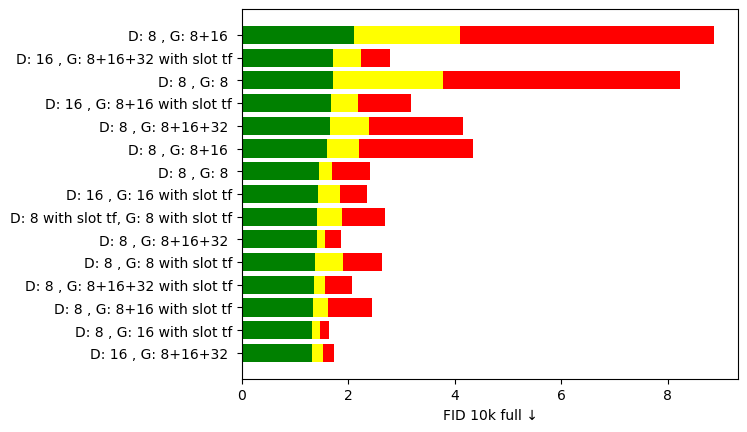

In [10]:
fig, ax = plt.subplots(1, 1)
for i, (name, min, mean, max) in enumerate(best_fids):
    ax.barh(i, max, label=name, color="red")
    ax.barh(i, mean, label=name, color="yellow")
    ax.barh(i, min, label=name, color="green")
ax.set_yticks(range(len(best_fids)))
ax.set_yticklabels(list(map(lambda x: x[0], best_fids)))
ax.set_xlabel("FID 10k full ↓")
plt.show()

In [11]:
all_fids = [
    (
        make_nice_name(name), 
        list(range(len(results))),
        list(map(lambda x: float(x["results"]["fid10k_full"]), results)),
    )
    for i, (name, results) in enumerate(fid_files)
]

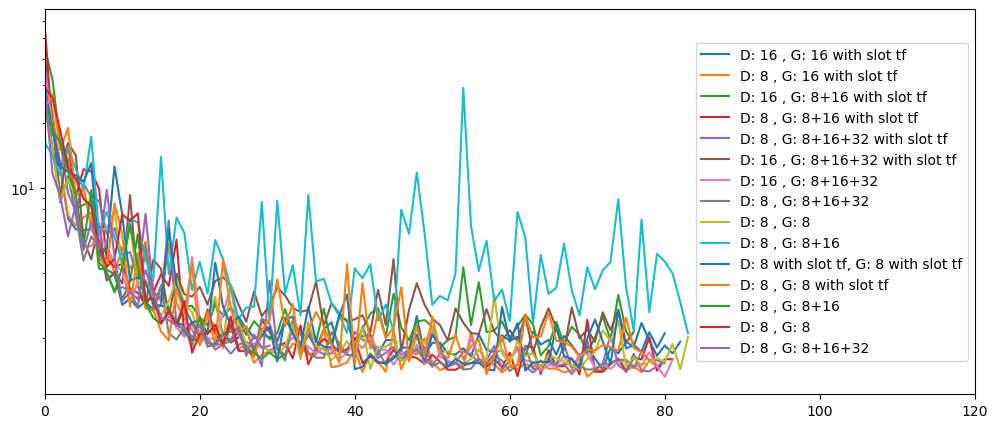

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
for name, ticks, fid in all_fids:
    plt.plot(ticks, fid, label=name)
plt.legend(loc="right")
plt.xlim(0, 120)
plt.yscale("log")
plt.show()

In [13]:
eval_slots_fn = list(map(lambda x: (x, make_eval_slots_function(x)), folders))

Note: random G has mse ~0.16, std ~0.014

In [14]:
eval_slots_fn

[('mlcloud_runs/00052-fastgan-clever6-gpus1-batch64-disc_d256_gen_feat16_sa',
  <function __main__.make_eval_slots_function.<locals>.f(n=10000, batch_size=8)>),
 ('mlcloud_runs/00053-fastgan-clever6-gpus1-batch64-disc_d512_gen_feat16_sa',
  <function __main__.make_eval_slots_function.<locals>.f(n=10000, batch_size=8)>),
 ('mlcloud_runs/00055-fastgan-clever6-gpus1-batch64-disc_d256_gen_feat8+16_sa',
  <function __main__.make_eval_slots_function.<locals>.f(n=10000, batch_size=8)>),
 ('mlcloud_runs/00056-fastgan-clever6-gpus1-batch64-disc_d512_gen_feat8+16_sa',
  <function __main__.make_eval_slots_function.<locals>.f(n=10000, batch_size=8)>),
 ('mlcloud_runs/00058-fastgan-clever6-gpus1-batch64-disc_d512_gen_feat8+16+32_sa',
  <function __main__.make_eval_slots_function.<locals>.f(n=10000, batch_size=8)>),
 ('mlcloud_runs/00059-fastgan-clever6-gpus1-batch64-disc_d256_gen_feat8+16+32_sa',
  <function __main__.make_eval_slots_function.<locals>.f(n=10000, batch_size=8)>),
 ('mlcloud_runs/0006

In [15]:
out = []
for name, fn in eval_slots_fn:
    out.append((make_nice_name(name), fn()))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [04:52<00:00,  4.28it/s]


In [123]:
import pickle
with open("results_slot_mse.pkl", "wb") as f:
    pickle.dump(out, f)
out

[('D: 16 , G: 16 with slot tf',
  (tensor(0.0305, device='cuda:0'), {'std': tensor(0.0132, device='cuda:0')})),
 ('D: 8 , G: 16 with slot tf',
  (tensor(0.0276, device='cuda:0'), {'std': tensor(0.0133, device='cuda:0')})),
 ('D: 16 , G: 8+16 with slot tf',
  (tensor(0.0312, device='cuda:0'), {'std': tensor(0.0142, device='cuda:0')})),
 ('D: 8 , G: 8+16 with slot tf',
  (tensor(0.0288, device='cuda:0'), {'std': tensor(0.0134, device='cuda:0')})),
 ('D: 8 , G: 8+16+32 with slot tf',
  (tensor(0.0287, device='cuda:0'), {'std': tensor(0.0125, device='cuda:0')})),
 ('D: 16 , G: 8+16+32 with slot tf',
  (tensor(0.0309, device='cuda:0'), {'std': tensor(0.0136, device='cuda:0')})),
 ('D: 16 , G: 8+16+32 ',
  (tensor(0.0265, device='cuda:0'), {'std': tensor(0.0130, device='cuda:0')})),
 ('D: 8 , G: 8+16+32 ',
  (tensor(0.0317, device='cuda:0'), {'std': tensor(0.0136, device='cuda:0')})),
 ('D: 8 , G: 8 ',
  (tensor(0.0329, device='cuda:0'), {'std': tensor(0.0143, device='cuda:0')})),
 ('D: 8 , 

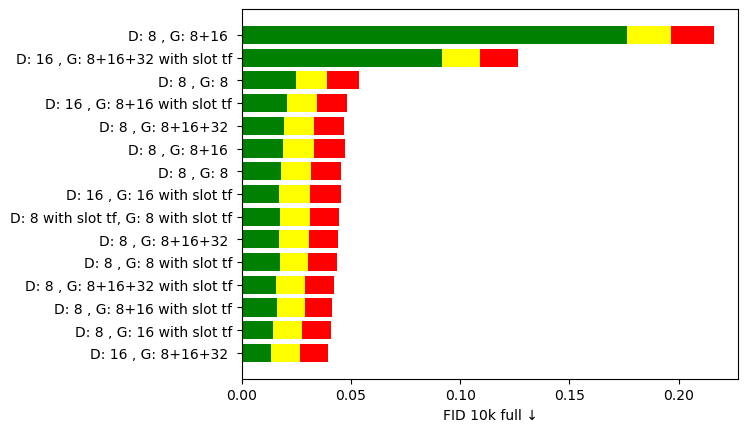

In [21]:
fig, ax = plt.subplots(1, 1)
out_sorted = sorted(out, key=lambda x: x[1][0])
for i, (name, (mean, other)) in enumerate(out_sorted):
    mean = mean.detach().cpu().numpy()
    std = other["std"].detach().cpu().numpy()
    ax.barh(i, mean+std, label=name, color="red")
    ax.barh(i, mean, label=name, color="yellow")
    ax.barh(i, mean-std, label=name, color="green")
ax.set_yticks(range(len(best_fids)))
ax.set_yticklabels(list(map(lambda x: x[0], best_fids)))
ax.set_xlabel("FID 10k full ↓")
plt.show()

In [82]:
best_fids = [
    (
        make_nice_name(name), 
        np.mean(list(map(lambda x: float(x["results"]["fid10k_full"]), results[-10:]))),
        np.std(list(map(lambda x: float(x["results"]["fid10k_full"]), results[-10:]))),
    )
    for i, (name, results) in enumerate(fid_files)
]
best_fids = sorted(best_fids, reverse=False, key=lambda x: x[1])

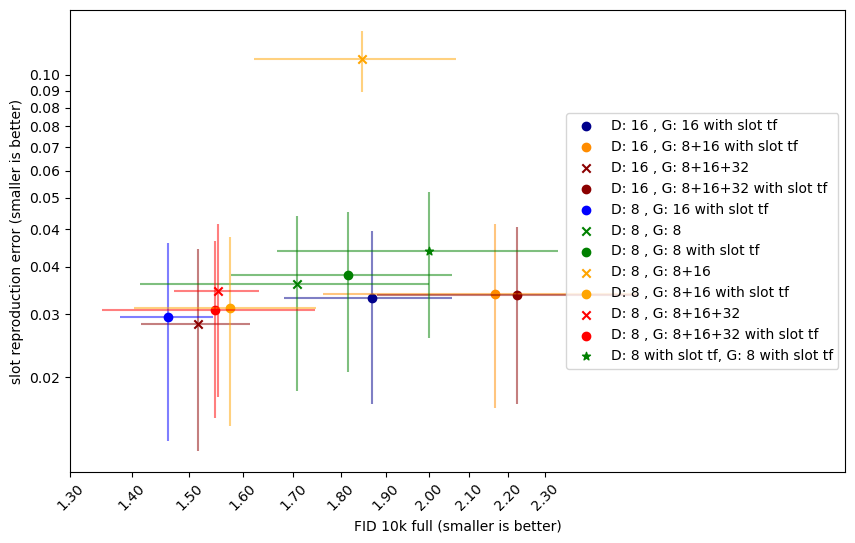

In [121]:
already_seen = set()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
out_sorted_by_name = sorted(out, key=lambda x: x[0])
best_fids_sorted_by_name = sorted(best_fids, key=lambda x: x[0])
for i, ((name_slots, (mean_slots, other)), (name_fid, mean_fid, std_fid)) in enumerate(zip(out_sorted_by_name, best_fids_sorted_by_name)):
    assert name_fid == name_slots
    
    if name_fid in already_seen:
        continue
    already_seen.add(name_fid)
    
    mean_slots = mean_slots.detach().cpu().numpy()
    std_slots = other["std"].detach().cpu().numpy()
    
    marker = ""
    if len(name_fid.split("tf")) >= 3:
        marker = "*"
    elif len(name_fid.split("tf")) == 2:
        marker = "o"
    else:
        marker = "x"
        
    color = ""
    if "G: 8" in name_fid and not "G: 8+" in name_fid:
        color="green"
    elif "G: 16" in name_fid and not "G: 16+" in name_fid:
        color="blue"
    elif "G: 8+16" in name_fid and not "G: 8+16+" in name_fid:
        color="orange"
    elif "G: 8+16+32" in name_fid:
        color="red"
    if "D: 16" in name_fid:
        color = "dark" + color
    
    
    
    ax.errorbar(mean_fid, mean_slots, xerr=std_fid, yerr=std_slots, alpha=0.5, color=color)
    ax.scatter(mean_fid, mean_slots, label=name_slots, marker=marker, color=color)
ax.set_xlabel("FID 10k full (smaller is better)")
ax.set_ylabel("slot reproduction error (smaller is better)")
ax.legend(loc="right")
ax.set_xscale("log")
ax.set_yscale("log")
x_space = np.linspace(1.3,2.3, 11)
ax.set_xlim([x_space.min(), (x_space.max() - x_space.min())*2+x_space.min()])
ax.set_xticks(x_space)
ax.set_xticks([], minor=True)
ax.set_xticklabels([f"{x:2.2f}" for x in x_space], rotation=45)


y_space = np.linspace(0.02,0.1, 11)
ax.set_yticks(y_space, minor=False)
ax.set_yticks([], minor=True)
ax.set_yticklabels([f"{y:2.2f}" for y in y_space], rotation=0, minor=False)

plt.savefig("images/ablation_study_direct_clever.pdf")
plt.show()